In [1]:
import sympy
from sympy.tensor.tensor import TensorIndexType, TensorIndex, TensorHead, tensor_indices, TensorSymmetry
from einsteinpy.symbolic import RicciTensor, RicciScalar, MetricTensor, ChristoffelSymbols

sympy.init_printing()

### Quadratic Action

First compute the action that is quadratic in the perturbations.

Start with the Ricci scalar.

In [2]:
syms = sympy.symbols("r psi theta phi")
r, psi, theta, phi = syms

In [3]:
L = sympy.symbols("L")  # AdS length scale
r_0 = sympy.symbols("r_0")

In [4]:
# perturbation of the spherical part of the metric
g = sympy.Function('g')(r)
delta_g = sympy.Function('delta_g')(r)

In [5]:
# perturbation of radial part of the metric
f = sympy.Function('f')(r)
delta_f = sympy.Function('delta_f')(r)

In [6]:
# perturbation of gauge field
Phi = sympy.Function('Phi')(r)
delta_Phi = sympy.Function('delta_\Phi')(r)

In [7]:
list2d = [[0 for i in range(4)] for i in range(4)]
list2d[0][0] = 1 / f
list2d[1][1] = list2d[2][2] = list2d[3][3] = g / 4
list2d[1][3] = list2d[3][1] = g / 4 * sympy.cos(theta)
sch = MetricTensor(list2d, syms)
sch.tensor()

⎡ 1                                  ⎤
⎢────       0        0         0     ⎥
⎢f(r)                                ⎥
⎢                                    ⎥
⎢         g(r)            g(r)⋅cos(θ)⎥
⎢ 0       ────       0    ───────────⎥
⎢          4                   4     ⎥
⎢                                    ⎥
⎢                   g(r)             ⎥
⎢ 0         0       ────       0     ⎥
⎢                    4               ⎥
⎢                                    ⎥
⎢      g(r)⋅cos(θ)           g(r)    ⎥
⎢ 0    ───────────   0       ────    ⎥
⎣           4                 4      ⎦

In [8]:
Ric = RicciTensor.from_metric(sch)

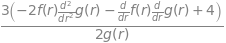

In [9]:
R = RicciScalar.from_riccitensor(Ric)
R.simplify()
R.expr

Next compute the Maxwell field contribution to the action.

In [10]:

A_1 = L / 2 * Phi * sympy.Array([0, 0, -sympy.sin(psi), sympy.cos(psi) * sympy.sin(theta)])
A_2 = L / 2 * Phi * sympy.Array([0, 0, sympy.cos(psi), sympy.sin(psi) * sympy.sin(theta)])
A_3 = L / 2 * Phi * sympy.Array([0, 1, 0, sympy.cos(theta)])

In [11]:
A_1, A_2, A_3

⎛⎡      -L⋅Φ(r)⋅sin(ψ)   L⋅Φ(r)⋅sin(θ)⋅cos(ψ)⎤  ⎡      L⋅Φ(r)⋅cos(ψ)  L⋅Φ(r)⋅s
⎜⎢0  0  ───────────────  ────────────────────⎥, ⎢0  0  ─────────────  ────────
⎝⎣             2                  2          ⎦  ⎣            2                

in(ψ)⋅sin(θ)⎤  ⎡   L⋅Φ(r)     L⋅Φ(r)⋅cos(θ)⎤⎞
────────────⎥, ⎢0  ──────  0  ─────────────⎥⎟
 2          ⎦  ⎣     2              2      ⎦⎠

In [12]:
x = [r, psi, theta, phi]
def em_field_strength(A):
    """Compute EM field strength from the vector potential."""    
    F = sympy.MutableDenseNDimArray.zeros(4, 4)
    for i in range(4):
        for j in range(4):
            F[i, j] = sympy.diff(A[j], x[i]) - sympy.diff(A[i], x[j])
    return F

In [13]:
F_1 = em_field_strength(A_1)
F_2 = em_field_strength(A_2)
F_3 = em_field_strength(A_3)

In [14]:
metric_inv = sympy.simplify(sympy.Matrix(list2d).inv())
metric_inv

⎡f(r)       0         0         0      ⎤
⎢                                      ⎥
⎢           4               -4⋅cos(θ)  ⎥
⎢ 0    ────────────   0    ────────────⎥
⎢              2                   2   ⎥
⎢      g(r)⋅sin (θ)        g(r)⋅sin (θ)⎥
⎢                                      ⎥
⎢                     4                ⎥
⎢ 0         0        ────       0      ⎥
⎢                    g(r)              ⎥
⎢                                      ⎥
⎢       -4⋅cos(θ)               4      ⎥
⎢ 0    ────────────   0    ────────────⎥
⎢              2                   2   ⎥
⎣      g(r)⋅sin (θ)        g(r)⋅sin (θ)⎦

In [15]:
Euclidean = TensorIndexType('Euclidean', dummy_name='E')
i0, i1, i2, i3, i4, i5, i6, i7 = tensor_indices('i0:8', Euclidean)

In [16]:
FFgg_tensor = TensorHead('FFgg', [Euclidean] * 8)
FFgg_matrix = (
    sympy.tensorproduct(F_1, F_1, metric_inv, metric_inv) +
    sympy.tensorproduct(F_2, F_2, metric_inv, metric_inv) +
    sympy.tensorproduct(F_3, F_3, metric_inv, metric_inv)
)
repl = {FFgg_tensor(-i0, -i1, -i2, -i3, i4, i5, i6, i7): FFgg_matrix}

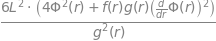

In [18]:
FF_contracted = sympy.simplify(FFgg_tensor(-i0, -i1, -i2, -i3, i3, i1, i2, i0).replace_with_arrays(repl))
FF_contracted

Compute the metric determinant.

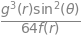

In [19]:
det_g = sympy.Matrix(sch.tensor()).det().simplify()
det_g

Get the integrand of the on-shell action.

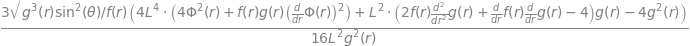

In [20]:
on_shell_action_integrand = -sympy.sqrt(det_g) * (R.expr + 6 / L ** 2 - FF_contracted)
on_shell_action_integrand.simplify()

Get the equations of motion that can be removed from the integrand.

In [23]:
metric_array = sympy.MutableDenseNDimArray(list2d)
einstein_tensor = sympy.MutableDenseNDimArray(Ric.tensor()) + 3 / L ** 2 * metric_array
einstein_tensor = sympy.simplify(einstein_tensor)
einstein_tensor

⎡      2                                                                      
⎢     d                      2                                                
⎢  3⋅───(g(r))     ⎛d       ⎞      d        d                                 
⎢      2         3⋅⎜──(g(r))⎟    3⋅──(f(r))⋅──(g(r))                          
⎢    dr            ⎝dr      ⎠      dr       dr            3                   
⎢- ─────────── + ───────────── - ─────────────────── + ───────                
⎢     2⋅g(r)           2             4⋅f(r)⋅g(r)        2                     
⎢                   4⋅g (r)                            L ⋅f(r)                
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [24]:
FFg_tensor = TensorHead('FFg', [Euclidean] * 6)
FFg_matrix = (
    sympy.tensorproduct(F_1, F_1, metric_inv) +
    sympy.tensorproduct(F_2, F_2, metric_inv) +
    sympy.tensorproduct(F_3, F_3, metric_inv)
)
repl = {FFg_tensor(-i0, -i1, -i2, -i3, i4, i5): FFg_matrix}
T_contracted_1 = FFg_tensor(-i0, -i1, -i2, -i3, i3, i1).replace_with_arrays(repl)
T_contracted_1 = sympy.simplify(T_contracted_1)

FFgg_tensor = TensorHead('FFgg', [Euclidean] * 8)
FFgg_matrix = (
    sympy.tensorproduct(F_1, F_1, metric_inv, metric_inv) +
    sympy.tensorproduct(F_2, F_2, metric_inv, metric_inv) +
    sympy.tensorproduct(F_3, F_3, metric_inv, metric_inv)
)
repl = {FFgg_tensor(-i0, -i1, -i2, -i3, i4, i5, i6, i7): FFgg_matrix}
T_contracted_2 = FFgg_tensor(-i0, -i1, -i2, -i3, i3, i1, i2, i0).replace_with_arrays(repl)
T_contracted_2 = sympy.simplify(T_contracted_2)

In [25]:
energy_momentum = 2 * (T_contracted_1 - metric_array / 4 * T_contracted_2)
energy_momentum = sympy.simplify(energy_momentum)
energy_momentum

⎡     ⎛                                2⎞                                     
⎢   2 ⎜     2                ⎛d       ⎞ ⎟                                     
⎢3⋅L ⋅⎜- 4⋅Φ (r) + f(r)⋅g(r)⋅⎜──(Φ(r))⎟ ⎟                                     
⎢     ⎝                      ⎝dr      ⎠ ⎠                                     
⎢────────────────────────────────────────                       0             
⎢                     2                                                       
⎢               f(r)⋅g (r)                                                    
⎢                                                                             
⎢                                                 ⎛                           
⎢                                                 ⎜                  ⎛d       
⎢                                                 ⎜        f(r)⋅g(r)⋅⎜──(Φ(r))
⎢                                               2 ⎜ 2                ⎝dr      
⎢                                              L ⋅⎜Φ

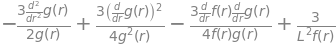

In [26]:
einstein_tensor[0, 0]

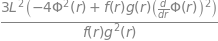

In [27]:
energy_momentum[0, 0]

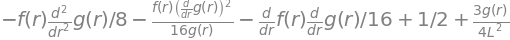

In [28]:
einstein_tensor[1, 1]

In [29]:
energy_momentum[1 ,1]

Get Maxwell's equations.

In [30]:
ch = ChristoffelSymbols.from_metric(sch)
ch = ch.tensor().simplify()
ch

⎡⎡ d                                                                         ⎤
⎢⎢-──(f(r))                                                                  ⎥
⎢⎢ dr                                                                        ⎥
⎢⎢──────────            0                    0                   0           ⎥
⎢⎢  2⋅f(r)                                                                   ⎥
⎢⎢                                                                           ⎥
⎢⎢                     d                                            d        ⎥
⎢⎢               -f(r)⋅──(g(r))                        -f(r)⋅cos(θ)⋅──(g(r)) ⎥
⎢⎢                     dr                                           dr       ⎥
⎢⎢    0          ───────────────             0         ──────────────────────⎥
⎢⎢                      8                                        8           ⎥
⎢⎢                                                                           ⎥
⎢⎢                                          d       

In [31]:
Fgg_tensor = TensorHead('Fgg', [Euclidean] * 6)
Fgg_matrix = sympy.tensorproduct(F_3, metric_inv, metric_inv)
repl = {Fgg_tensor(-i0, -i1, i2, i3, i4, i5): Fgg_matrix}
F_upper_indices = Fgg_tensor(-i0, -i1, i0, i2, i1, i3).replace_with_arrays(repl)
F_upper_indices = sympy.simplify(F_upper_indices)
F_upper_indices

⎡                              d                                   ⎤
⎢                     2⋅L⋅f(r)⋅──(Φ(r))                            ⎥
⎢                              dr                                  ⎥
⎢         0           ─────────────────       0             0      ⎥
⎢                            g(r)                                  ⎥
⎢                                                                  ⎥
⎢          d                                                       ⎥
⎢-2⋅L⋅f(r)⋅──(Φ(r))                                                ⎥
⎢          dr                             -8⋅L⋅Φ(r)                ⎥
⎢───────────────────          0          ────────────       0      ⎥
⎢        g(r)                             2                        ⎥
⎢                                        g (r)⋅tan(θ)              ⎥
⎢                                                                  ⎥
⎢                         8⋅L⋅Φ(r)                      -8⋅L⋅Φ(r)  ⎥
⎢         0             ──────────

In [32]:
partial_F = sympy.MutableDenseNDimArray.zeros(4, 4, 4)
for i in range(4):
    for j in range(4):
        for k in range(4):
            partial_F[i, j, k] = sympy.diff(F_upper_indices[j, k], x[i]) 

In [33]:
partial_F_tensor = TensorHead('partialF', [Euclidean] * 3)
repl = {partial_F_tensor(-i0, i1, i2): partial_F}
partial_F_contracted = partial_F_tensor(-i0, i0, i1).replace_with_arrays(repl)

In [34]:
lambda_F_tensor = TensorHead('lambdaF', [Euclidean] * 5)
lambda_F_matrix = sympy.tensorproduct(ch, F_upper_indices)
repl = {lambda_F_tensor(i0, -i1, -i2, i3, i4): lambda_F_matrix}
partial_F_contracted += lambda_F_tensor(i0, -i0, -i1, i1, i2).replace_with_arrays(repl)
partial_F_contracted += lambda_F_tensor(i0, -i1, -i2, i1, i2).replace_with_arrays(repl)
partial_F_contracted = sympy.simplify(partial_F_contracted)
partial_F_contracted

⎡     ⎛⎛         2                          ⎞                                 
⎢     ⎜⎜        d          d        d       ⎟                      d        d 
⎢   L⋅⎜⎜2⋅f(r)⋅───(Φ(r)) + ──(Φ(r))⋅──(f(r))⎟⋅g(r) - 8⋅Φ(r) + f(r)⋅──(Φ(r))⋅──
⎢     ⎜⎜         2         dr       dr      ⎟                      dr       dr
⎢     ⎝⎝       dr                           ⎠                                 
⎢0  ──────────────────────────────────────────────────────────────────────────
⎢                                          2                                  
⎣                                         g (r)                               

      ⎞      ⎤
      ⎟      ⎥
(g(r))⎟      ⎥
      ⎟      ⎥
      ⎠      ⎥
───────  0  0⎥
             ⎥
             ⎦

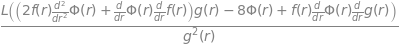

In [35]:
partial_F_contracted[1]

Compute the extrinsic curvature on the boundary.

In [36]:
gn_tensor = TensorHead('gn', [Euclidean] * 3)
repl = {gn_tensor(-i0, -i1, i2): sympy.tensorproduct(list2d, [1, 0, 0, 0])}
n_lower = sympy.simplify(gn_tensor(-i0, -i1, i1).replace_with_arrays(repl))
n_lower

⎡ 1           ⎤
⎢────  0  0  0⎥
⎣f(r)         ⎦

In [37]:
x = [r, psi, theta, phi]
partial_n = sympy.MutableDenseNDimArray.zeros(4, 4)
for i in range(4):
    for j in range(4):
            partial_n[i, j] = sympy.diff(n_lower[j], x[i]) 
partial_n

⎡ d                 ⎤
⎢-──(f(r))          ⎥
⎢ dr                ⎥
⎢──────────  0  0  0⎥
⎢   2               ⎥
⎢  f (r)            ⎥
⎢                   ⎥
⎢    0       0  0  0⎥
⎢                   ⎥
⎢    0       0  0  0⎥
⎢                   ⎥
⎣    0       0  0  0⎦

In [38]:
lambda_n_tensor = TensorHead('lambdan', [Euclidean] * 4)
repl = {lambda_n_tensor(i0, -i1, -i2, -i3): sympy.tensorproduct(ch, n_lower)}
partial_n -= lambda_n_tensor(i0, -i1, -i2, -i0).replace_with_arrays(repl)
partial_n = sympy.simplify(partial_n)
partial_n

⎡ d                                                    ⎤
⎢-──(f(r))                                             ⎥
⎢ dr                                                   ⎥
⎢──────────         0            0             0       ⎥
⎢    2                                                 ⎥
⎢ 2⋅f (r)                                              ⎥
⎢                                                      ⎥
⎢               d                              d       ⎥
⎢               ──(g(r))                cos(θ)⋅──(g(r))⎥
⎢               dr                             dr      ⎥
⎢    0          ────────         0      ───────────────⎥
⎢                  8                           8       ⎥
⎢                                                      ⎥
⎢                             d                        ⎥
⎢                             ──(g(r))                 ⎥
⎢                             dr                       ⎥
⎢    0              0         ────────         0       ⎥
⎢                              

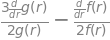

In [39]:
g_partial_n_tensor = TensorHead('gpartialn', [Euclidean] * 4)
repl = {g_partial_n_tensor(i0, i1, -i2, -i3): sympy.tensorproduct(metric_inv, partial_n)}
K = sympy.simplify(g_partial_n_tensor(i0, i1, -i0, -i1).replace_with_arrays(repl))
K

In [40]:
induced_metric_list = [[0 for i in range(3)] for i in range(3)]
induced_metric_list[0][0] = induced_metric_list[1][1] = induced_metric_list[2][2] = g / 4
induced_metric_list[0][2] = induced_metric_list[2][0] = g / 4 * sympy.cos(theta)
induced_metric = MetricTensor(induced_metric_list, (psi, theta, phi))
induced_metric.tensor()

⎡   g(r)            g(r)⋅cos(θ)⎤
⎢   ────       0    ───────────⎥
⎢    4                   4     ⎥
⎢                              ⎥
⎢             g(r)             ⎥
⎢     0       ────       0     ⎥
⎢              4               ⎥
⎢                              ⎥
⎢g(r)⋅cos(θ)           g(r)    ⎥
⎢───────────   0       ────    ⎥
⎣     4                 4      ⎦

In [41]:
det_h = sympy.Matrix(induced_metric.tensor()).det().simplify()
det_h

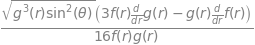

In [42]:
ghy_term = sympy.sqrt(det_h) * K
ghy_term.simplify()

Compute the counterterms.

In [43]:
Ric_induced = RicciTensor.from_metric(induced_metric)
Ric_induced.tensor().simplify()

⎡             cos(θ)⎤
⎢ 1/2     0   ──────⎥
⎢               2   ⎥
⎢                   ⎥
⎢  0     1/2    0   ⎥
⎢                   ⎥
⎢cos(θ)             ⎥
⎢──────   0    1/2  ⎥
⎣  2                ⎦

In [44]:
R_induced = RicciScalar.from_riccitensor(Ric_induced)
R_induced.simplify()
R_induced.expr

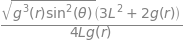

In [45]:
counterterms = 4 / L * sympy.sqrt(det_h) + L * sympy.sqrt(det_h) * R_induced.expr
counterterms.simplify()